# ME5311-CFD: your 2nd CFD problem
## Xinyu Zhao 

### 1D transient conduction in a semi-infinite wall

Transient conduction in a semi-infinite wall is a common problem that can be encountered in engineering, for example, when heat transfer along a large thin wall with small thermal conductivity is of interest. The governing equation is a parabolic partial differential equation, 

$$ \rho c \frac{\partial T}{\partial t} = \frac{\partial}{\partial x}(k\frac{\partial T}{\partial x}) $$

with boundary conditions,

$$ T(x,0) = T_i, x > 0 $$
$$ T(0,t) = T_s, t > 0 $$
$$ T(x \to \infty, t) = T_i,  t > 0$$

The numerical solution of this problem exercises spatial and temporal discretization. In particular, this is a good example to understand accuracy versus stability of a numerical method. A first-order explicit method is used to advance the solution in time, while a second-order central difference is used to discretize the spatial derivative term. The initial time step $dt$ is chosen to be right at the stability limit. Readers can increase dt to be larger than the default value to observe numerical instability.  

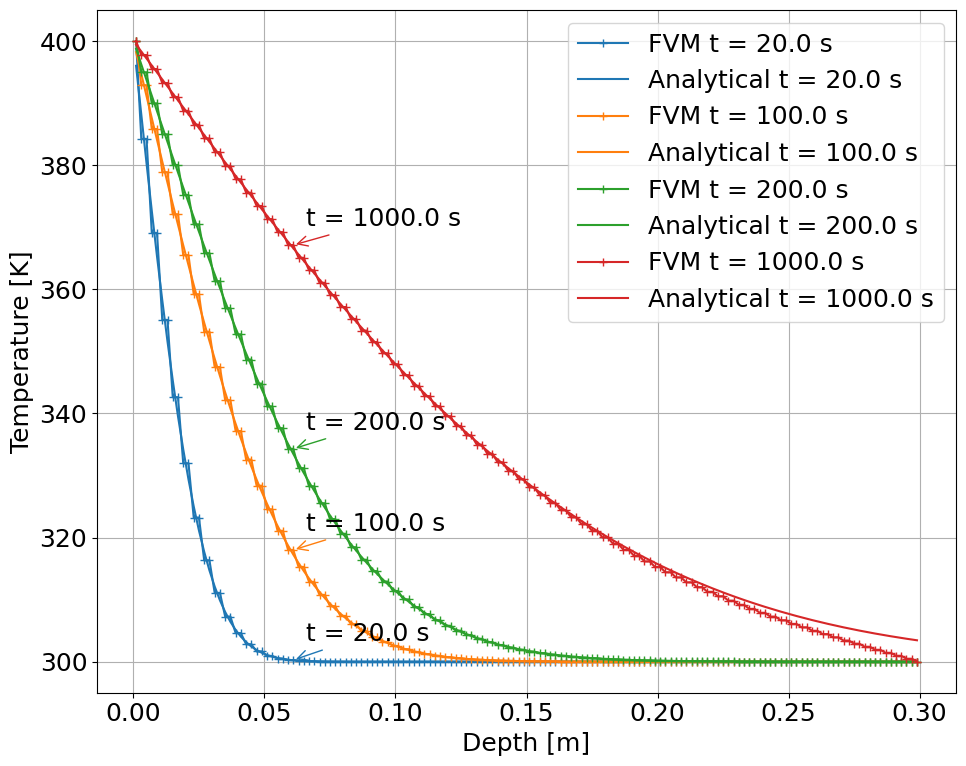

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Physical and numerical parameters
alpha = 1e-5       # thermal diffusivity [m^2/s]
L = 0.3            # wall depth [m]
N = 150             # number of cells (a finite volume method)
dx = L / N          # cell size for the numerical solution 
dt = 0.5*dx**2 / alpha # time step chosen. Note that 0.5 * dx**2 / alpha is the upper limit for obtaining stable solution
Nt = 5000 # number of total time steps
T_i = 300 # initial temperature of the whole domain 
T_s = 400 # boundary temperature at x = 0, at t > 0 

# Spatial grid (cell centers)
x = np.linspace(dx/2, L - dx/2, N)

# Initial condition
T = np.ones(N) * T_i
# Boundary condition
T[0] = T_s

# Time snapshots and storage
snapshots = [100, 500, 1000, 5000]
T_record = {} # empty array to host the numerical solution for T
T_analytical = {} # empty array to host the analytical solution at the same location as the numerical solution

# explicit time stepping
for n in range(1, Nt + 1):
    T_old = T.copy() # store a copy of the existing solution obtained from the previous time step
    for i in range(1, N - 1):
        T[i] = T_old[i] + alpha * dt / dx**2 * (T_old[i+1] - 2*T_old[i] + T_old[i-1]) # Eq. 3.63 in the book 
    T[0] =  T_old[0] + alpha * dt / dx**2 * (T_old[1] - 3*T_old[0] + 2*T_s) # taking care of the boundary condition at x = 0
    T[N-1]= T_old[N-1] + alpha * dt / dx**2 * (T_old[N-2] - 3*T_old[N-1] + 2*T_i) #taking care of the boundary condition at x = L
    
    if n in snapshots:
        T_record[n] = T.copy() # store the latest solution to the array, adding it to the last column
        t_now = n * dt
        T_analytical[n] = T_s + (T_i - T_s) * erf(x / (2 * np.sqrt(alpha * t_now))) # computing and store analytical solution at the same time step

# Plotting with time annotations
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for idx, n in enumerate(snapshots):
    t_now = n * dt
    label_text = f't = {t_now:.1f} s'
    
    # Plot numerical and analytical
    plt.plot(x, T_record[n], '-+', color=colors[idx], label=f'FVM {label_text}')
    plt.plot(x, T_analytical[n], '-', color=colors[idx], label=f'Analytical {label_text}')
    
    # Annotate time on the FVM curve
    i_annot = int(len(x) * 0.2)  # location to annotate
    plt.annotate(label_text,
                 xy=(x[i_annot], T_record[n][i_annot]),
                 xytext=(x[i_annot] + 0.005, T_record[n][i_annot] + 3),
                 fontsize=18,
                 arrowprops=dict(arrowstyle='->', color=colors[idx]))

plt.xlabel('Depth [m]', fontsize=18)
plt.ylabel('Temperature [K]', fontsize=18)
#plt.title('1D Transient Heat Conduction into Semi-Infinite Wall\n(FVM vs Analytical)', fontsize=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Comments 

The above figure shows the temperature evolution at 20, 100, 200 and 1000~s, compared to the analytical solutions, using $\Delta t = 0.1$~s. Great agreement is achieved between the numerical and analytical solutions, verifying that the numerical procedure is correct. It is noteworthy that the temperature beyond 0.2~m is unaffected by the sudden increase of temperature (or appears to have no knowledge of the change) on the left boundary by 200 seconds. This is because diffusion occurs at finite rates, and at 200~seconds with a diffusivity of $10^{-5}$, the length scale for diffusion can be estimated using $2\sqrt{\alpha t}$ as indicated by the similarity variable, which gives a value of 0.04~m. This estimated distance is on the same order of magnitude with the observation from the results here. Further advancement in time makes the temperature significantly different from the initial temperature at the right boundary when using $L=0.3$. In other words, $L=0.3$~m violates the assumptions of semi-infinite domain in the analytical solution. As a result, a deviation between the numerical solution is observed from the analytical solution at $t=1000$~s. 


We use this Jupyter notebook to explore the idea of self-similarity.
The following figure shows the same solutions after normalization, using the variables $\theta$ and $\eta$. All the results at different physical time instants collapse with one another, which is the meaning or signature of a ``self-similar solution''. The solution at $t = 1000$~s slightly deviates from the rest of the profiles, since it violates the semi-infinite domain assumption, as discussed above. 

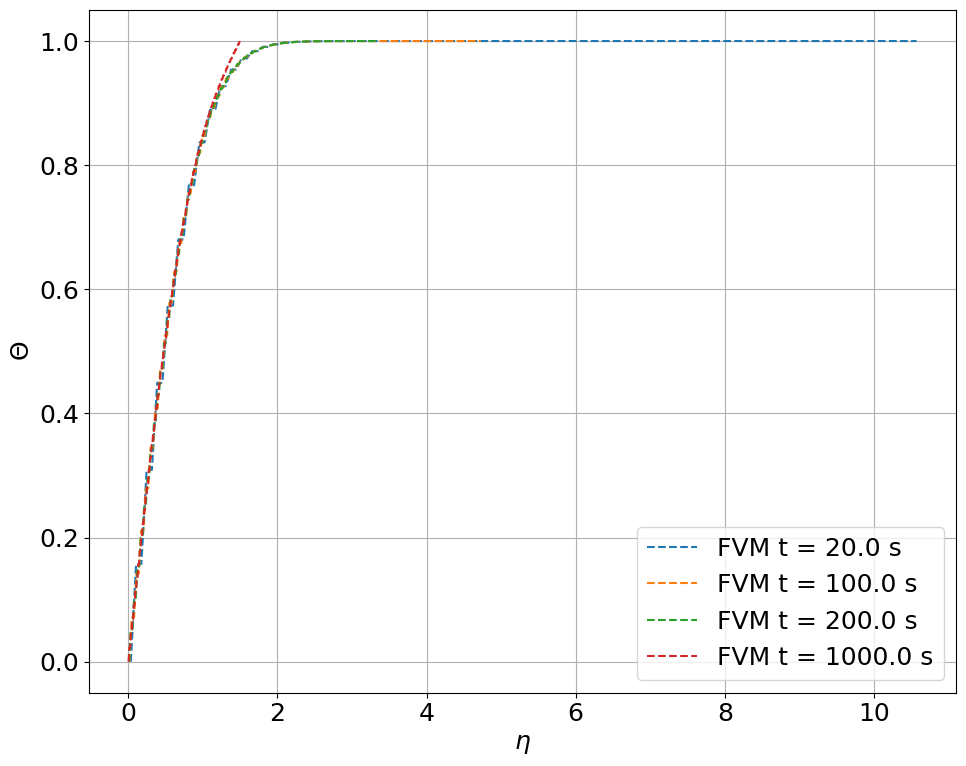

In [8]:
# Plotting with time annotations
# Plot the solution in the similarity coordinate eta = x / sqrt(alpha * t)

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for idx, n in enumerate(snapshots):
    t_now = n * dt
    label_text = f't = {t_now:.1f} s'
    
    theta = (T_record[n] - T_s)/(T_i - T_s)
    eta = x/2/np.sqrt(alpha*t_now)
    # Plot numerical and analytical
    plt.plot(eta, theta, '--', color=colors[idx], label=f'FVM {label_text}')
    
    # Annotate time on the FVM curve
    i_annot = int(len(x) * 0.2)  # location to annotate
    plt.annotate(label_text,
                 xy=(x[i_annot], T_record[n][i_annot]),
                 xytext=(x[i_annot] + 0.005, T_record[n][i_annot] + 3),
                 fontsize=18,
                 arrowprops=dict(arrowstyle='->', color=colors[idx]))

plt.xlabel('$\eta$', fontsize=18)
plt.ylabel('$\Theta$', fontsize=18)
#plt.title('1D Transient Heat Conduction into Semi-Infinite Wall\n(FVM vs Analytical)', fontsize=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Exercise 1 

Change the time step to be twice the current value and observe the temperature profiles. Comment on the results. 

### Excercise 2 

Discretize the governing equation using a first-order implicit time-stepping scheme and program an implicit solver for the same problem. Once the program is ready, solve the problem using two time steps dt = 0.5*dx^2 / alpha and dt = dx^2 / alpha. Compare to results from the explicit time-stepping scheme in terms of accuracy and stability. 